Heteroscedastic Implementation of Deep Ensembles

no adversarial Training is used

Most of the code inspired by:
https://github.com/cameronccohen/deep-ensembles/blob/master/Tutorial.ipynb

Necessary imports

In [1]:
import os
import sys
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
import optuna
from optuna.trial import TrialState
import uncertainty_toolbox as uct
import time

# define the device for the setting
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# check the computer name and set the path accordingly
if os.environ['COMPUTERNAME'] == 'FYNN':            # name of surface PC
    sys.path.append(r'C:\Users\Surface\Masterarbeit')
elif os.environ['COMPUTERNAME'] == 'FYNNS-PC':  # desktop name
    sys.path.append(r'C:\Users\test\Masterarbeit')
    
else:
    raise ValueError("Unbekannter Computername: " + os.environ['COMPUTERNAME'])

from utils.data_prep import load_tranform_and_split_data, set_seed
from utils.metrices import evaluate_intervals
from utils.NN_model import Custom_NN_Model, train_model, heteroscedastic_loss
from utils.NN_model import create_ensemble

Load, Transform and Split the data

In [2]:
#load and transform the data, split it into training, validation, and test sets
# the split ratio is 60% training, 20% validation, and 20%
# return the feature names for later use
X_train, X_val, X_test, y_train, y_val, y_test, feature_names = load_tranform_and_split_data('C1_V01_delta_kan', split_ratio=(0.6, 0.2, 0.2))

# convert the data to PyTorch tensors
# and add an extra dimension for the target variable
X_train_tensor = torch.from_numpy(X_train).float()
X_val_tensor = torch.from_numpy(X_val).float()
X_test_tensor = torch.from_numpy(X_test).float()
y_train_tensor = torch.from_numpy(y_train).float().reshape(-1,1) # Add extra dimension for compatibility
y_val_tensor = torch.from_numpy(y_val).float().reshape(-1,1)
y_test_tensor = torch.from_numpy(y_test).float().reshape(-1,1)

Optuna Hyperparameter Search

In [ ]:
def objective(trial):
    
    # hyperparameter for sampling with Optuna
    n_layer = trial.suggest_int("n_layer", 2, 5)  # number of hidden layers
    n_neurons = trial.suggest_int("n_neurons", 64, 320, step=32)  # number of neurons in each hidden layer
    lr = trial.suggest_float("lr", 1e-4, 1e-2, log=True)    # learning rate
    batch_size = trial.suggest_categorical("batch_size", [64, 128]) 
    decay = trial.suggest_float('decay', 0.5, 0.7, step = 0.1)

    # decay factor for the number of neurons in each layer
    # e.g. if n_neurons = 256 and n_layer = 3
    # then the hidden_dims will be [256, 128, 64]
    # this creates a list of integers representing the number of neurons in each hidden layer
    hidden_dims = [int(n_neurons * decay**i) for i in range(n_layer)]
    print(f"Hidden dimensions: {hidden_dims}")
        
    # generate the model with the sampled hyperparameters
    # and move it to the device (GPU or CPU)
    model = Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=hidden_dims,
        output_dim=1,
        do_rate=0,
        loss_type = 'heteroscedastic'
    ).to(device)

    # AdamW optimizer, where weight decay does not accumulate in the momentum nor variance.
    optimizer = torch.optim.AdamW(params = model.parameters(), lr = lr, weight_decay=0.0001)  

    # DataLoader for batching the data
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # integrate early stopping
    patience = 20  # number of epochs with no improvement after which training will be stopped
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # training the model
    for epoch in range(epochs):
        model.train()
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)  # Move data to the device (GPU or CPU)
            y_batch = y_batch.to(device)
            optimizer.zero_grad()
            
            loss = heteroscedastic_loss(model, X_batch, y_batch)
            loss.backward()
            optimizer.step()
            
        # validation loss calculation after each epoch
        model.eval()
        with torch.no_grad():
            val_loss = heteroscedastic_loss(model, X_val_tensor, y_val_tensor)
        
        # report the validation loss to Optuna
        trial.report(val_loss, step=epoch)
        # handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        
        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
           
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch+1}, Best Val Loss: {best_val_loss:.4f}")
                break
    
    return best_val_loss

In [ ]:
# number of epochs for training
epochs = 500

# create a study object for Optuna
study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(),                       #TPE (Tree-structured Parzen Estimator) sampler by default
    pruner=optuna.pruners.MedianPruner(        
        n_startup_trials=20,                                    # Number of trials to run before pruning starts
        n_warmup_steps=5                                        # Number of warmup steps before pruning starts)
    )
)

# move the tensors to the device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)
X_val_tensor = X_val_tensor.to(device)
y_val_tensor = y_val_tensor.to(device)

# optimize the objective function with Optuna
# timeout=None means no time limit for the optimization, all trials will be run
study.optimize(objective, n_trials=200, timeout=None, n_jobs=1, show_progress_bar=True)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

print("Study statistics: ")
print("  Number of finished trials: ", len(study.trials))
print("  Number of pruned trials: ", len(pruned_trials))
print("  Number of complete trials: ", len(complete_trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Create an Ensemble, train it and make predictions

best Model Architectur implemented:
hidden_dims=[320,224,156]

Best trial:
  Value:  1.4413212537765503
  Params: 
    n_layer: 3
    n_neurons: 320
    lr: 0.0004348009611810878
    batch_size: 64
    decay: 0.7

In [17]:
net = Custom_NN_Model(
        input_dim=X_train_tensor.shape[1],
        hidden_dims=[320,224,156],
        output_dim=1,
        do_rate=0,
        loss_type = 'heteroscedastic'
    ).to(device)
optimizer = torch.optim.AdamW(params = net.parameters(), lr = 0.0001, weight_decay=0.0001)
model1 = train_model(model= net, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
                    X_val_tensor= X_val_tensor, y_val_tensor=y_val_tensor, batch_size=64, 
                    optimizer=optimizer, n_epochs=1000, patience=50, loss_type='heteroscedastic',
                    )

Using device: cuda
Epoch 1/1000, Train Loss: 522.9876, Val Loss: 6.6945, Best Val Loss: 6.6945
Epoch 2/1000, Train Loss: 5.8651, Val Loss: 5.5703, Best Val Loss: 5.5703
Epoch 3/1000, Train Loss: 5.5277, Val Loss: 5.5006, Best Val Loss: 5.5006
Epoch 4/1000, Train Loss: 5.4858, Val Loss: 5.4681, Best Val Loss: 5.4681
Epoch 5/1000, Train Loss: 5.4547, Val Loss: 5.4375, Best Val Loss: 5.4375
Epoch 6/1000, Train Loss: 5.4239, Val Loss: 5.4063, Best Val Loss: 5.4063
Epoch 7/1000, Train Loss: 5.3917, Val Loss: 5.3730, Best Val Loss: 5.3730
Epoch 8/1000, Train Loss: 5.3561, Val Loss: 5.3354, Best Val Loss: 5.3354
Epoch 9/1000, Train Loss: 5.3144, Val Loss: 5.2902, Best Val Loss: 5.2902
Epoch 10/1000, Train Loss: 5.2630, Val Loss: 5.2332, Best Val Loss: 5.2332
Epoch 11/1000, Train Loss: 5.1968, Val Loss: 5.1564, Best Val Loss: 5.1564
Epoch 12/1000, Train Loss: 5.0995, Val Loss: 5.0301, Best Val Loss: 5.0301
Epoch 13/1000, Train Loss: 4.8993, Val Loss: 4.6902, Best Val Loss: 4.6902
Epoch 14/1000

In [19]:
model1.cpu()
model1.eval() 
with torch.no_grad():   
    output_mean, output_log_var = model1(X_test_tensor.cpu())

In [3]:
#create an ensemble of 5 networks with the defined net architecture and optimizer
nets_ops = create_ensemble(5, input_dim = X_train.shape[1], hidden_dims=[320,224,156], 
                           do_rate=0, loss_type='heteroscedastic', lr=0.0004, weight_decay=0.0001)

# lists to store the output means and log variances of each network in the ensemble
outputs_mean = []
outputs_log_var = []

train_times = []
pred_times = []

#train the ensemble of networks and make predictions on the test set
for net, ops in nets_ops:
    start_train = time.perf_counter()
    model = train_model(model= net, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
                        X_val_tensor= X_val_tensor, y_val_tensor=y_val_tensor, batch_size=64, 
                        optimizer=ops, n_epochs=1000, patience=50, loss_type='heteroscedastic',
                        )
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    train_time = time.perf_counter() - start_train
    train_times.append(train_time)
    print(f"Training time for this model: {train_time:.4f} seconds")
    print("Model training mode:", model.training)

    # set the model to evaluation mode and make predictions on the test set
    model.eval()   
        # --- prediction time ---
    if torch.cuda.is_available():
        torch.cuda.synchronize()
    start_pred = time.perf_counter()

    print("Model training mode:", model.training)
    with torch.no_grad():
        output_mean, output_log_var = model(X_test_tensor.to(device))
        if torch.cuda.is_available():
            torch.cuda.synchronize()

        output_mean_np, output_log_var_np = output_mean.detach().cpu().numpy(), output_log_var.detach().cpu().numpy()
        outputs_mean.append(output_mean_np)
        outputs_log_var.append(np.exp(output_log_var_np))
        pred_time = time.perf_counter() - start_pred
        pred_times.append(pred_time)

outputs_mean = np.array(outputs_mean)
outputs_log_var = np.array(outputs_log_var)
print(f"Train times (s): {train_times}")
print(f"Prediction times (s): {pred_times}")

Using device: cuda
Epoch 1/1000, Train Loss: 133.2339, Val Loss: 5.5547, Best Val Loss: 5.5547
Epoch 2/1000, Train Loss: 5.4808, Val Loss: 5.4084, Best Val Loss: 5.4084
Epoch 3/1000, Train Loss: 5.3600, Val Loss: 5.3127, Best Val Loss: 5.3127
Epoch 4/1000, Train Loss: 5.2746, Val Loss: 5.2341, Best Val Loss: 5.2341
Epoch 5/1000, Train Loss: 5.1776, Val Loss: 5.0900, Best Val Loss: 5.0900
Epoch 6/1000, Train Loss: 3.7884, Val Loss: 2.3260, Best Val Loss: 2.3260
Epoch 7/1000, Train Loss: 2.1868, Val Loss: 2.1120, Best Val Loss: 2.1120
Epoch 8/1000, Train Loss: 2.0184, Val Loss: 1.9830, Best Val Loss: 1.9830
Epoch 9/1000, Train Loss: 1.9246, Val Loss: 1.8810, Best Val Loss: 1.8810
Epoch 10/1000, Train Loss: 1.8695, Val Loss: 1.8453, Best Val Loss: 1.8453
Epoch 11/1000, Train Loss: 1.8191, Val Loss: 1.8175, Best Val Loss: 1.8175
Epoch 12/1000, Train Loss: 1.7879, Val Loss: 1.7776, Best Val Loss: 1.7776
Epoch 14/1000, Train Loss: 1.7460, Val Loss: 1.7428, Best Val Loss: 1.7428
Epoch 17/1000

In [4]:
print(np.sum(train_times)/60)
print(np.sum(pred_times))

29.368738085000466
0.04472899984102696


Evaluating the Model

DE Mean shape: (10403,)
DE Mean: [111.16658  103.839615 118.50136  ... 121.4084   122.03428  111.72101 ]
Epistemic Variance: 1.020178
Aleatoric Variance: 8.606825
 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.98it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.00it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.963
  RMSE          2.792
  MDAE          1.441
  MARPD         1.714
  R2            0.863
  Correlation   0.929
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.043
  Mean-absolute Calibration Error       0.039
  Miscalibration Area                   0.040
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.051
     Group Size: 0.56 -- Calibration Error: 0.043
     Group Size: 1.00 -- Calibration Error: 0.039
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.059
     Group Size: 0.56 -- Calibration Error: 0.046
     Group Size: 1.00 -- Calibration Error: 0.043
================

<Axes: title={'center': 'Adversarial Group Calibration'}, xlabel='Group size', ylabel='Calibration Error of Worst Group'>

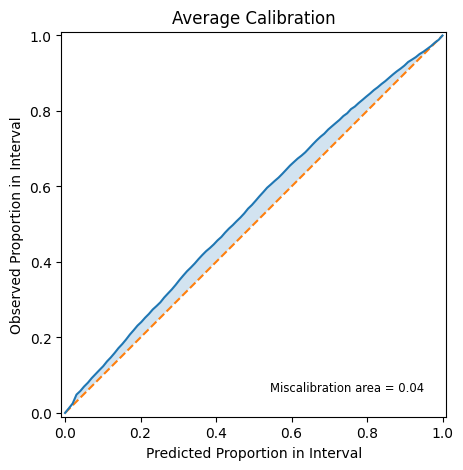

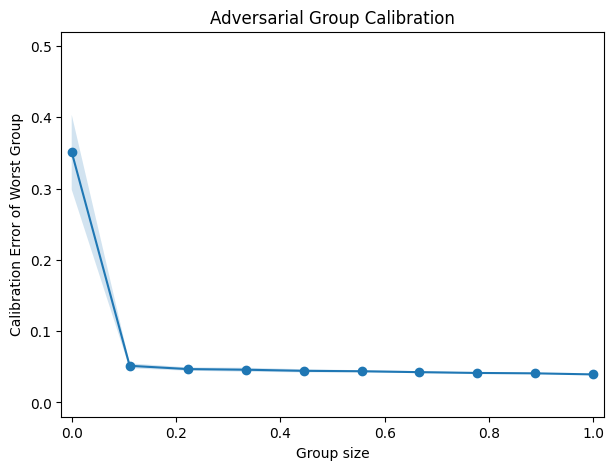

In [9]:
# Calculate the mean and standard deviation of the predictions on the test data
DE_mean = np.mean(outputs_mean, axis = 0).reshape(-1)

# Calculate epistemic
epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
print(f"Epistemic Variance: {epistemic_var_heteroscedastic.mean():.6f}")

# Calculate aleatoric variance (heteroscedastic)
aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
print(f"Aleatoric Variance: {aleatoric_var_heteroscedastic.mean():.6f}")

# Calculate total standard deviation
DE_std = np.sqrt(epistemic_var_heteroscedastic + aleatoric_var_heteroscedastic).reshape(-1)

# Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
pnn_metrics = uct.metrics.get_all_metrics( DE_mean, DE_std, y_test)
print(pnn_metrics)
print(pnn_metrics['accuracy']['rmse'])
# Calculate coverage for 95% confidence interval
coverage_95 = uct.metrics_calibration.get_proportion_in_interval(DE_mean, DE_std, y_test, quantile = 0.95 )
print(f"Coverage 95%: {coverage_95}")

# use own function to calculate coverage and MPIW
ev_intervals = evaluate_intervals(DE_mean, DE_std, y_test, coverage=0.95)
print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

# calibration Curve with UCT
uct.viz.plot_calibration(DE_mean, DE_std, y_test)

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(DE_mean, DE_std, y_test)

Evaluate Deep Ensemble predictions with 10 runs

In [3]:
results_list = []
predictions_list = []
list_of_seeds = [42, 123, 777, 2024, 5250, 8888, 9876, 10001, 31415, 54321]
DE_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\Deep Ensembles"
DE_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\Deep Ensembles"

for run, seed in enumerate(list_of_seeds):

    print(f"Run {run+1} with seed {seed}")
    set_seed(seed)

    #create an ensemble of 5 networks with the defined net architecture and optimizer
    nets_ops = create_ensemble(5, input_dim = X_train.shape[1], hidden_dims=[320,224,156], 
                            do_rate=0, loss_type='heteroscedastic', lr=0.0004, weight_decay=0.0001)

    # lists to store the output means and log variances of each network in the ensemble
    outputs_mean = []
    outputs_log_var = []

    #train the ensemble of networks and make predictions on the test set
    for net, ops in nets_ops:
        model = train_model(model= net, X_train_tensor=X_train_tensor, y_train_tensor=y_train_tensor,
                            X_val_tensor= X_val_tensor, y_val_tensor=y_val_tensor, batch_size=64, 
                            optimizer=ops, n_epochs=1000, patience=50, loss_type='heteroscedastic',
                            )

        # set the model to evaluation mode and make predictions on the test set
        model.eval()   
        with torch.no_grad():
            output_mean, output_log_var = model(X_test_tensor.to(device))
            # Detach and convert to numpy arrays
            output_mean_np, output_log_var_np = output_mean.detach().cpu().numpy(), output_log_var.detach().cpu().numpy()
            outputs_mean.append(output_mean_np)
            outputs_log_var.append(np.exp(output_log_var_np))

    outputs_mean = np.array(outputs_mean)
    outputs_log_var = np.array(outputs_log_var)

    # Calculate the mean and standard deviation of the predictions on the test data
    DE_mean = np.mean(outputs_mean, axis = 0).reshape(-1) # reshape to 1D array

    # Calculate epistemic
    DE_epistemic_var_heteroscedastic = np.var(outputs_mean, axis=0)
    print(f"Epistemic Variance: {DE_epistemic_var_heteroscedastic.mean():.6f}")

    # Calculate aleatoric variance (heteroscedastic)
    DE_aleatoric_var_heteroscedastic = np.mean(outputs_log_var, axis=0)
    print(f"Aleatoric Variance: {DE_aleatoric_var_heteroscedastic.mean():.6f}")

    # Calculate total standard deviation
    DE_std = np.sqrt(DE_epistemic_var_heteroscedastic + DE_aleatoric_var_heteroscedastic).reshape(-1) # reshape to 1D array

    # Calculate and print all metrics inclunding RMSE, MAE, R²-Score, NLL, CRPS
    pnn_metrics = uct.metrics.get_all_metrics(DE_mean, DE_std, y_test)
    print(pnn_metrics)

    # use own function to calculate coverage and MPIW
    ev_intervals = evaluate_intervals(DE_mean, DE_std, y_test, coverage=0.95)
    print(f'coverage: {ev_intervals["coverage"]}, MPIW: {ev_intervals["MPIW"]}')

    predictions_per_run = {
        'mean_prediction': DE_mean,
        'std_prediction': DE_std,
    }

    results_per_run = {
    'RMSE': pnn_metrics['accuracy']['rmse'],
    'MAE': pnn_metrics['accuracy']['mae'],
    'R2': pnn_metrics['accuracy']['r2'], 
    'Correlation' : pnn_metrics['accuracy']['corr'],
    'NLL': pnn_metrics['scoring_rule']['nll'],
    'CRPS': pnn_metrics['scoring_rule']['crps'],
    'coverage': ev_intervals["coverage"],
    'MPIW': ev_intervals["MPIW"],
    }

    predictions_list.append(predictions_per_run)
    results_list.append(results_per_run)
#save the predictions 
with open(os.path.join(DE_prediction_path, "DE_predictions_list.pkl"), "wb") as f:
    pickle.dump(predictions_list, f)

#save the results in an excel file
results_df = pd.DataFrame(results_list)
results_df.to_excel(os.path.join(DE_result_path, "DE_results.xlsx"), index=False)

Run 1 with seed 42
Using device: cuda
Epoch 1/1000, Train Loss: 142.1510, Val Loss: 5.5156, Best Val Loss: 5.5156
Epoch 2/1000, Train Loss: 5.4695, Val Loss: 5.4248, Best Val Loss: 5.4248
Epoch 3/1000, Train Loss: 5.3937, Val Loss: 5.3583, Best Val Loss: 5.3583
Epoch 4/1000, Train Loss: 5.3288, Val Loss: 5.2952, Best Val Loss: 5.2952
Epoch 5/1000, Train Loss: 5.2648, Val Loss: 5.2313, Best Val Loss: 5.2313
Epoch 6/1000, Train Loss: 5.1928, Val Loss: 5.1450, Best Val Loss: 5.1450
Epoch 7/1000, Train Loss: 5.0568, Val Loss: 4.9153, Best Val Loss: 4.9153
Epoch 8/1000, Train Loss: 3.7240, Val Loss: 2.3674, Best Val Loss: 2.3674
Epoch 9/1000, Train Loss: 2.2071, Val Loss: 2.1284, Best Val Loss: 2.1284
Epoch 10/1000, Train Loss: 2.0266, Val Loss: 1.9779, Best Val Loss: 1.9779
Epoch 11/1000, Train Loss: 1.9279, Val Loss: 1.9249, Best Val Loss: 1.9249
Epoch 12/1000, Train Loss: 1.8630, Val Loss: 1.8318, Best Val Loss: 1.8318
Epoch 13/1000, Train Loss: 1.8270, Val Loss: 1.8175, Best Val Loss: 1

100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.10it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.966
  RMSE          2.765
  MDAE          1.457
  MARPD         1.717
  R2            0.866
  Correlation   0.931
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.032
  Mean-absolute Calibration Error       0.028
  Miscalibration Area                   0.028
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.041
     Group Size: 0.56 -- Calibration Error: 0.032
     Group Size: 1.00 -- Calibration Error: 0.028
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.044
     Group Size: 0.56 -- Calibration Error: 0.036
     Group Size: 1.00 -- Calibration Error: 0.032
================

100%|██████████| 10/10 [00:02<00:00,  4.13it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.987
  RMSE          2.817
  MDAE          1.482
  MARPD         1.735
  R2            0.861
  Correlation   0.928
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.035
  Mean-absolute Calibration Error       0.032
  Miscalibration Area                   0.032
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.043
     Group Size: 0.56 -- Calibration Error: 0.036
     Group Size: 1.00 -- Calibration Error: 0.032
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.047
     Group Size: 0.56 -- Calibration Error: 0.039
     Group Size: 1.00 -- Calibration Error: 0.035
================

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.07it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.955
  RMSE          2.772
  MDAE          1.437
  MARPD         1.707
  R2            0.865
  Correlation   0.930
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.038
  Mean-absolute Calibration Error       0.035
  Miscalibration Area                   0.035
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.047
     Group Size: 0.56 -- Calibration Error: 0.038
     Group Size: 1.00 -- Calibration Error: 0.035
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.052
     Group Size: 0.56 -- Calibration Error: 0.041
     Group Size: 1.00 -- Calibration Error: 0.038
================

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.980
  RMSE          2.797
  MDAE          1.465
  MARPD         1.729
  R2            0.863
  Correlation   0.929
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.030
  Mean-absolute Calibration Error       0.026
  Miscalibration Area                   0.027
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.038
     Group Size: 0.56 -- Calibration Error: 0.030
     Group Size: 1.00 -- Calibration Error: 0.026
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.046
     Group Size: 0.56 -- Calibration Error: 0.035
     Group Size: 1.00 -- Calibration Error: 0.030
================

100%|██████████| 10/10 [00:02<00:00,  4.09it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.08it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.968
  RMSE          2.774
  MDAE          1.463
  MARPD         1.719
  R2            0.865
  Correlation   0.931
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.028
  Mean-absolute Calibration Error       0.025
  Miscalibration Area                   0.025
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.035
     Group Size: 0.56 -- Calibration Error: 0.029
     Group Size: 1.00 -- Calibration Error: 0.025
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.039
     Group Size: 0.56 -- Calibration Error: 0.031
     Group Size: 1.00 -- Calibration Error: 0.028
================

100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.11it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.989
  RMSE          2.786
  MDAE          1.473
  MARPD         1.736
  R2            0.864
  Correlation   0.930
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.039
  Mean-absolute Calibration Error       0.034
  Miscalibration Area                   0.035
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.047
     Group Size: 0.56 -- Calibration Error: 0.038
     Group Size: 1.00 -- Calibration Error: 0.034
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.051
     Group Size: 0.56 -- Calibration Error: 0.043
     Group Size: 1.00 -- Calibration Error: 0.039
================

100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.981
  RMSE          2.793
  MDAE          1.491
  MARPD         1.730
  R2            0.863
  Correlation   0.929
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.024
  Mean-absolute Calibration Error       0.021
  Miscalibration Area                   0.021
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.033
     Group Size: 0.56 -- Calibration Error: 0.025
     Group Size: 1.00 -- Calibration Error: 0.021
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.037
     Group Size: 0.56 -- Calibration Error: 0.030
     Group Size: 1.00 -- Calibration Error: 0.024
================

100%|██████████| 10/10 [00:02<00:00,  4.05it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.03it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.977
  RMSE          2.766
  MDAE          1.457
  MARPD         1.727
  R2            0.866
  Correlation   0.931
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.033
  Mean-absolute Calibration Error       0.028
  Miscalibration Area                   0.028
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.044
     Group Size: 0.56 -- Calibration Error: 0.031
     Group Size: 1.00 -- Calibration Error: 0.028
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.046
     Group Size: 0.56 -- Calibration Error: 0.036
     Group Size: 1.00 -- Calibration Error: 0.033
================

100%|██████████| 10/10 [00:02<00:00,  4.19it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  4.14it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.002
  RMSE          2.835
  MDAE          1.488
  MARPD         1.748
  R2            0.859
  Correlation   0.927
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.056
  Mean-absolute Calibration Error       0.049
  Miscalibration Area                   0.050
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.060
     Group Size: 0.56 -- Calibration Error: 0.053
     Group Size: 1.00 -- Calibration Error: 0.049
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.068
     Group Size: 0.56 -- Calibration Error: 0.060
     Group Size: 1.00 -- Calibration Error: 0.056
================

100%|██████████| 10/10 [00:02<00:00,  3.55it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:02<00:00,  3.57it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           2.000
  RMSE          2.804
  MDAE          1.498
  MARPD         1.746
  R2            0.862
  Correlation   0.929
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.034
  Mean-absolute Calibration Error       0.030
  Miscalibration Area                   0.030
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.041
     Group Size: 0.56 -- Calibration Error: 0.033
     Group Size: 1.00 -- Calibration Error: 0.030
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.051
     Group Size: 0.56 -- Calibration Error: 0.039
     Group Size: 1.00 -- Calibration Error: 0.034
================

In [3]:
DE_prediction_path = r"C:\Users\test\Masterarbeit\models\Modelresults\Deep Ensembles"
DE_result_path = r"C:\Users\test\OneDrive\Master Management und Engineering\Masterarbeit\Experimente\Evaluation\10 Runs\Deep Ensembles"
with open(os.path.join(DE_prediction_path, "DE_predictions_list.pkl"), "rb") as f:
    predictions_list = pickle.load(f)

mean_list = []
std_list = []

for id, run in enumerate(predictions_list):
    # extract mean and std predictions
    mean = run['mean_prediction']
    std = run['std_prediction']
    
    # append to lists
    mean_list.append(mean)
    std_list.append(std)
    
    # calibration Curve with UCT
    uct.viz.plot_calibration(mean, std, y_test)
    plt.savefig(os.path.join(DE_result_path, f"calibration_run_{id+1}.svg"), format ='svg')
    plt.savefig(os.path.join(DE_result_path, f"calibration_run_{id+1}.png"), format ='png')
    plt.close()

    # adversarial group calibration
    uct.viz.plot_adversarial_group_calibration(mean, std, y_test)
    plt.savefig(os.path.join(DE_result_path, f"adversarial_group_calibration_run_{id+1}.svg"), format ='svg')
    plt.savefig(os.path.join(DE_result_path, f"adversarial_group_calibration_run_{id+1}.png"), format ='png')
    plt.close()

# predictions_list enthält pro Run ein Array mit 10403 Werten
mean_matrix = np.array(mean_list)  # Shape: (n_runs, 10403)
std_matrix = np.array(std_list)    # Shape: (n_runs, 10403)

# Mittelwert und Std für jeden Datenpunkt über alle Runs
mean_per_datapoint = np.mean(mean_matrix, axis=0)  # Shape: (10403,)
std_per_datapoint = np.mean(std_matrix, axis=0)    # Shape: (10403,)

# calibration Curve with UCT
uct.viz.plot_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(DE_result_path, "calibration_run_mean.svg"), format ='svg')
plt.savefig(os.path.join(DE_result_path, "calibration_run_mean.png"), format ='png')
plt.close()

# adversarial group calibration
uct.viz.plot_adversarial_group_calibration(mean_per_datapoint, std_per_datapoint, y_test)
plt.savefig(os.path.join(DE_result_path, "adversarial_group_calibration_run_mean.svg"), format ='svg')
plt.savefig(os.path.join(DE_result_path, "adversarial_group_calibration_run_mean.png"), format ='png')
plt.close()